In [4]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import sys
import copy
from pprint import pprint

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer

dump_dir = os.path.abspath('../.log')

def get_model_fns(sweep_id):
	api = wandb.Api()
	sweep = api.sweep(sweep_id)
	models = []
	for run in sweep.runs:
		if "models_dir" not in run.summary:
			continue

		ckpts = []
		ckpt_dir = run.summary["models_dir"]
		ckpt_fns = [os.path.join(ckpt_dir, f) for f in os.listdir(ckpt_dir)]
		ckpt_fns = [f for f in ckpt_fns if os.path.isfile(f)]

		models.append(ckpt_fns)

	return models

def parse_dump(dump):
    ts = dump.get('ts')
    true_zt = dump.get('true_zt')
    pred_zt = dump.get('pred_zt')
    return ts, true_zt, pred_zt

def download_runs_sweep(sweep_id):
    api = wandb.Api()
    sweep = api.sweep(sweep_id)
    for run in sweep.runs:
        download_root = os.path.join(dump_dir, sweep.name, run.name)
        for f in run.files():
            if f.name == 'data.pt':
                print(run.name)
                fpath = os.path.join(download_root, f.name)
                if not os.path.isfile(fpath):
                    f.download(root=download_root)
                yield run.name, run.config, parse_dump(torch.load(fpath))

In [6]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

sweep_id = "ql88qelm"
sweep_id = "physics-uncertainty-exps/{}".format(sweep_id)

model_fns = get_model_fns(sweep_id)

for _, cfg, (ts, true_zt, pred_zt) in download_runs_sweep(sweep_id):
    break
    
cfg.pop('uq_type')
cfg.pop('C')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body)

CHNN-UNC--889467


In [7]:
for fns in model_fns[:1]:    
    for fn in fns[::10]:
        print(fn)
        
        state_dict = torch.load(fn)
        trainer.model.load_state_dict(state_dict)
    
        pred_zt = trainer.model(true_zt[:,0].to("cuda"), ts.to("cuda"))
        pred_zt = pred_zt.detach().cpu()
        
        rel_err = compute_rel_error(true_zt, pred_zt)
        err_geom_mean = compute_geom_mean(ts, rel_err)

        print(err_geom_mean.mean().item())

/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_0.pt
0.8138812184333801
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_10.pt
0.47869372367858887
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_20.pt
0.34439998865127563
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_30.pt
0.3125773072242737
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_40.pt
0.2660963833332062
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_50.pt
0.2767447829246521
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_60.pt
0.20214290916919708
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_70.pt
0.22210970520973206
/misc/vlgscratch4/WilsonGroup/ngruver/logs/chnn_ensemble_diversity/tmp8b9oymo3/model_80.pt
0.1271592676639557
/misc/v

In [8]:
sweep_id = "ql88qelm"
sweep_id = "physics-uncertainty-exps/{}".format(sweep_id)

model_fns = get_model_fns(sweep_id)

In [9]:
def get_preds(model, loader):
    preds = []
    for (z0, ts), true_zs in loader:
        with torch.no_grad():
            xp0 = model.to_pos_momentum(z0)
            t0 = ts[0,0]
            preds.append(model.dynamics(t0,xp0))
    preds = torch.cat(preds, dim=0)
    return preds

def get_ensemble_preds(ensemble, loader):
    preds = []
    for model in ensemble:
        preds.append(get_preds(model, loader).flatten())
    preds = torch.stack(preds, dim=0)
    return preds
        
log_dir = os.path.join(os.environ["LOGDIR"], "CHNN_ensembles")

train_loader = copy.deepcopy(trainer._trainers[0].dataloaders["train"])
test_loader = copy.deepcopy(trainer._trainers[0].dataloaders["test"])

train_preds = []
test_preds = []

for fns in model_fns:
    _train_preds = []
    _test_preds = []
    
    for fn in fns:
        state_dict = torch.load(fn)
        trainer.model.load_state_dict(state_dict)
    
        _train_preds.append(get_ensemble_preds(trainer.model.ensemble, train_loader))
        _test_preds.append(get_ensemble_preds(trainer.model.ensemble, test_loader))

    train_preds.append(torch.stack(_train_preds, dim=0))
    test_preds.append(torch.stack(_test_preds, dim=0))
    
train_preds = torch.stack(train_preds, dim=0)
test_preds = torch.stack(test_preds, dim=0)

print(train_preds.size())
print(test_preds.size())

torch.Size([9, 100, 5, 9600])
torch.Size([9, 100, 5, 2400])


In [12]:
api = wandb.Api()
sweep = api.sweep(sweep_id)
for run in sweep.runs:
    print(run.config)

{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 3, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 1000}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 1, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 1000}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 2, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 1000}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 3, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 50}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 1, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 200}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 2, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 200}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 2, 'num_bodies': 3, 'num_epochs': 100, 'n_subsample': 50}
{'C': 5, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'net_seed': 1,

In [13]:
hd_train_preds = train_preds[:3]
hd_test_preds = test_preds[:3]
md_train_preds = torch.cat([train_preds[4:6], train_preds[8:9]], dim=0)
md_test_preds = torch.cat([test_preds[4:6], test_preds[8:9]], dim=0)
ld_train_preds = torch.cat([train_preds[3:4], train_preds[6:8]], dim=0)
ld_test_preds = torch.cat([test_preds[3:4], test_preds[6:8]], dim=0)

torch.Size([3, 100, 5, 9600])


In [14]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_embeddings(preds):
    unflat_size = preds.shape
    flat_train_preds = preds.reshape((-1, unflat_size[-1]))
    
    reducer = umap.UMAP()
    scaled_preds = StandardScaler().fit_transform(flat_train_preds)
    embedding = reducer.fit_transform(scaled_preds)
    embedding = embedding.reshape((unflat_size[0], unflat_size[1], -1))
    embedding = embedding.swapaxes(0, 1)
    
    return embedding

def plot_embeddings(embeddings):
    for idx, m_embeddings in enumerate(embeddings):
        plt.plot(m_embeddings[:,0], m_embeddings[:,1], label=str(idx))
    plt.legend()
    plt.show()
    plt.close()

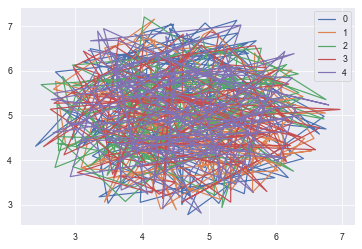

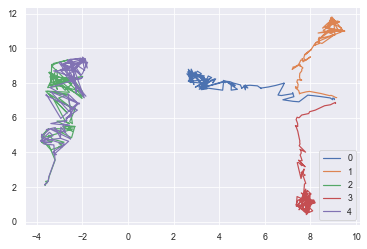

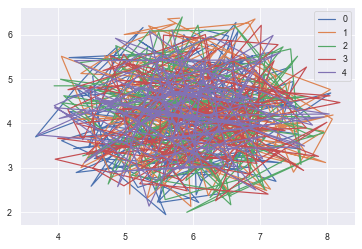

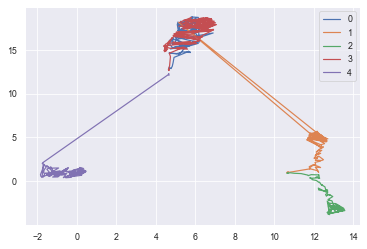

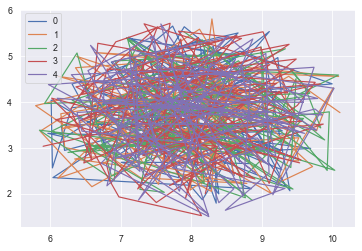

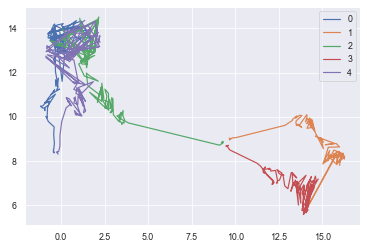

In [15]:
for train_preds, test_preds in zip(ld_train_preds, ld_test_preds):
    train_embeddings = get_embeddings(train_preds.cpu().detach().numpy())
    test_embeddings = get_embeddings(test_preds.cpu().detach().numpy())
    plot_embeddings(train_embeddings)
    plot_embeddings(test_embeddings)

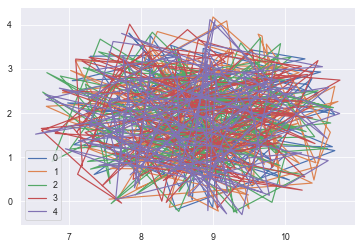

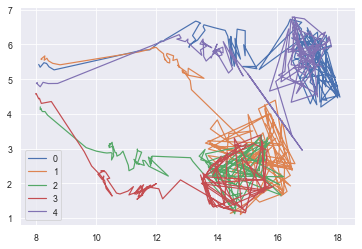

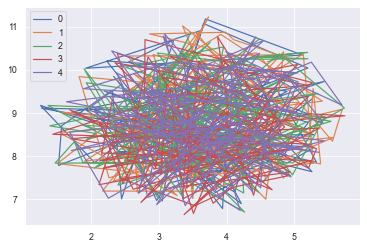

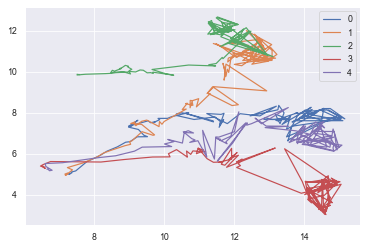

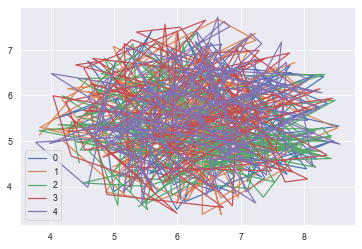

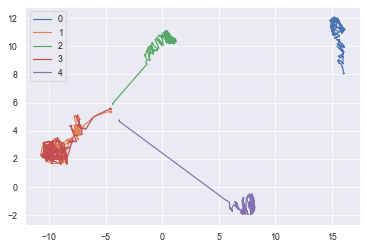

In [16]:
for train_preds, test_preds in zip(md_train_preds, md_test_preds):
    train_embeddings = get_embeddings(train_preds.cpu().detach().numpy())
    test_embeddings = get_embeddings(test_preds.cpu().detach().numpy())
    plot_embeddings(train_embeddings)
    plot_embeddings(test_embeddings)

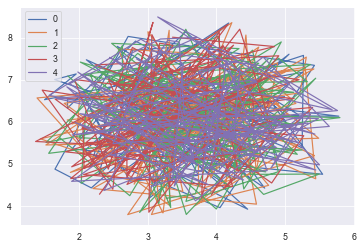

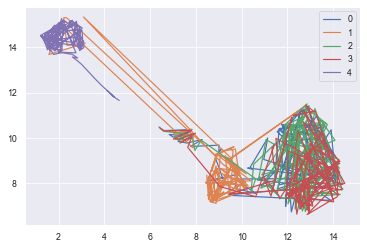

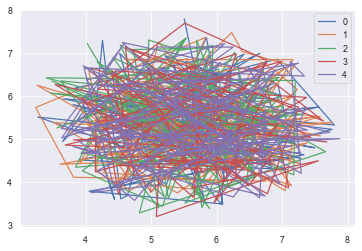

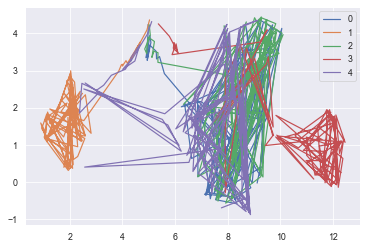

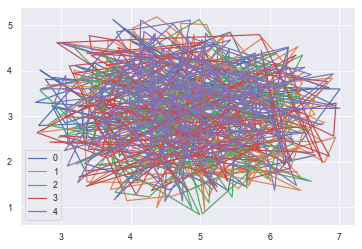

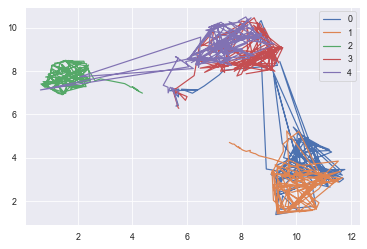

In [17]:
for train_preds, test_preds in zip(hd_train_preds, hd_test_preds):
    train_embeddings = get_embeddings(train_preds.cpu().detach().numpy())
    test_embeddings = get_embeddings(test_preds.cpu().detach().numpy())
    plot_embeddings(train_embeddings)
    plot_embeddings(test_embeddings)

In [18]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

In [39]:
def compare_ensemble_indv_loss(true_zt, pred_zt, ts):
    means, stds = [], []
    for i in range(pred_zt.size(0)):
        rel_err = compute_rel_error(true_zt, pred_zt[i])
        err_geom_mean = compute_geom_mean(ts, rel_err)
        means.append(err_geom_mean.mean().item())
        stds.append(err_geom_mean.std().item())
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    err_geom_mean = compute_geom_mean(ts, rel_err)
    means.append(err_geom_mean.mean().item())
    stds.append(err_geom_mean.std().item())
    
    errs = [s / 5. for s in stds]
    
    labels = [str(i) for i in range(pred_zt.size(0))] + ["ensemble"]

    x = np.arange(len(labels))
    width = 0.5

    plt.bar(x - width/2, means, width, yerr=errs)#, label="hnn-de")
    plt.xticks(x, labels)
    plt.legend()

    plt.show()
    plt.close()

def correlation_of_errs(true_zt, pred_zt):
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    scaled = StandardScaler().fit_transform(errs)
    cov = np.cov(scaled, rowvar=True)

    cols = [str(i) for i in range(len(cov))]
    plt.figure(figsize=cov.shape)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cov,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     yticklabels=cols,
                     xticklabels=cols)
    
    plt.show()
    plt.close()
    
def get_ensemble_loss(ensemble, z0, ts, true_zt):
    pred_zt = []
    for idx, model in enumerate(ensemble):
        print(idx)
        model = model.to("cpu")
        with torch.no_grad():
            pred = model.integrate(z0, ts, method='rk4')    
        pred_zt.append(pred)
    pred_zt = torch.stack(pred_zt, dim=0).cpu()
    
#     compare_ensemble_indv_loss(true_zt, pred_zt, ts)
#     correlation_of_errs(true_zt, pred_zt)
    
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    
    rel_err = compute_rel_error(true_zt, pred_zt)
    err_geom_mean = compute_geom_mean(ts, rel_err)
    
    return err_geom_mean.mean(1), errs

z0 = true_zt[:,0]

sweep_id = "785f3yp7"
sweep_id = "physics-uncertainty-exps/{}".format(sweep_id)

model_fns = get_model_fns(sweep_id)

means, errs = [], []
for save_fn in model_fns[0]:
#     save_fn = "ensemble_epoch_{}.pt".format(5 * epoch_step)
    
    state_dict = torch.load(save_fn)
    trainer.model.load_state_dict(state_dict)
    
    geom_mean, _errs = get_ensemble_loss(trainer.model.ensemble, z0, ts, true_zt)
    
    print(geom_mean)
    
    means.append(geom_mean)
    errs.append(_errs)

means = torch.stack(means, dim=1)
errs = torch.stack(errs, dim=1)

T = means.size(1)
for i in range(means.size(0)):
    plt.plot(range(T), means[i], label=str(i))
plt.show()
plt.close()

# for i in range(means.size(0)):
#     scaled = StandardScaler().fit_transform(errs[i])
#     cov = np.cov(scaled, rowvar=True)

#     cols = [str(i) for i in range(len(cov))]
#     plt.figure(figsize=cov.shape)
#     sns.set(font_scale=1.5)
#     hm = sns.heatmap(cov,
#                      cbar=True,
#                      annot=True,
#                      square=True,
#                      fmt='.2f',
#                      annot_kws={'size': 12},
#                      yticklabels=cols,
#                      xticklabels=cols)
    
#     plt.show()
#     plt.close()

0
1
2
3
4
tensor([0.9124, 0.8885, 0.9114, 0.9236, 0.9072])
0
1
2
3
4
tensor([0.9124, 0.8885, 0.9114, 0.9236, 0.9072])
0
1
2
3


KeyboardInterrupt: 

In [24]:
true_zt.size()

torch.Size([25, 334, 2, 3, 2])

In [25]:
ts.size()

torch.Size([334])